* By: Rino Hilman and Illya Barziy
* Email: rinohilman@yahoo.com and illyabarziy@gmail.com
* Reference: __Detection of False Investment Strategies using Unsupervised Learning Methods__  by Marcos Lopez de Prado and  Michael J. Lewis 


# Optimal Number of Clusters (ONC)


## Introduction

Optimal Number of Clusters algorithm has a purpose to detect the optimal number of K-Means clusters using feature correlation matrix and silhouette scores.
Implementations in this notebook are based on the paper __Detection of False Investment Strategies using Unsupervised Learning Methods__ [available here](https://papers.ssrn.com/sol3/abstract_id=3167017).

ONC algorithm takes as input:
- Correlation Matrix of elements
- Number of clusters to use (If not given, the algorithm will choose the optimal number of clusters)

And the output of the algorithm is:
- Correlation Matrix (order of elements is re-arranged so the elements from one cluster are placed near each other)
- Optimized Clusters (dictionary containing cluster number and elements that it contains)
- Silhouette Scores (Silhouette Scores of every element in clusters)


## Usage of the ONC algorithm

In the code below the random correlation matrix is generated and the ONC clustering algorithm is used on it. After, the result of clustering is assessed.

The code used in this part closely follows the code from the __Detection of False Investment Strategies using Unsupervised Learning Methods__ paper.

In [1]:
# Import necessary packages
import random
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.linalg import block_diag 
from sklearn.utils import check_random_state, shuffle
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import mlfinlab as ml
from mlfinlab.clustering.onc import get_onc_clusters

### Random Block Correlation Matrix Algorithm

We use a random correlation matrix generator taken from the book __"Machine Learning for Asset Managers"__, by _Marcos M. Lopez de Prado_,(Chapter 4, Page 61-62) to generate a random block of a correlation matrix.

In [2]:
def getCovSub(nObs, nCols, sigma, random_state=None): 
    '''
    Generates a block of a block-diagonal random covariance matrix.
    '''
    rng = check_random_state(random_state) 
    if nCols==1:return np.ones((1,1)) 
    ar0=rng.normal(size=(nObs,1))     
    ar0=np.repeat(ar0,nCols,axis=1)     
    ar0+=rng.normal(scale=sigma,size=ar0.shape)     
    ar0=np.cov(ar0,rowvar=False)     
    return ar0

In [3]:
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    '''
    Generates a whole block-diagonal random covariance matrix with a given number of blocks.
    '''    
    rng = check_random_state(random_state)     
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)     
    parts.sort()     
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)     
    parts=np.append(parts[0],np.diff( parts )) - 1 + minBlockSize     
    cov=None     
    for nCols_ in parts:         
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)         
        if cov is None:cov=cov_.copy()         
        else:cov=block_diag(cov,cov_)     
    return cov 

The function _cov_to_corr_ from MLFinLab package transforms covariance into a correlation matrix.

Class that contains this function is _ml.portfolio_optimization.RiskEstimators_.

In [4]:
# A class that contains the cov_to_corr function
risk_estimators = ml.portfolio_optimization.RiskEstimators()

In [5]:
def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):  
    '''
    Generates a whole block-diagonal random correlation matrix with noise added.
    '''
    # Form block correlation    
    rng = check_random_state(random_state)     
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,\
                        sigma=.5,random_state=rng) # perfect block corr     
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,\
                        sigma=1.,random_state=rng) # add noise     
    cov0+=cov1     
    corr0=risk_estimators.cov_to_corr(cov0)     
    corr0=pd.DataFrame(corr0)     
    return corr0

### Using the Random Block Correlation Matrix Algorithm

Executing the _randomBlockCorr_ function to create a random correlation matrix.

The created matrix will have 15 columns and 5 blocks that have a high intra-block correlation and inter-block correlation. It is done to represent real dependencies of clustered elements - they are related to elements in the same cluster stronger than to elements outside the cluster.

In [6]:
# Set predetermined variables for the algorithm
num_blocks = 5
num_cols = 15

# Setting a random seed to get the same results
np.random.seed(0)

In [7]:
# Generating a correlation matrix
corr_matrix = randomBlockCorr(num_cols, num_blocks, random_state=None, minBlockSize=1)

print('The random correlation matrix is:')
corr_matrix

The random correlation matrix is:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.668930,0.726645,0.666211,0.682333,0.386862,0.336758,0.421807,0.407746,0.406339,0.437698,0.336780,0.398266,0.373348,0.354250
1,0.668930,1.000000,0.681343,0.639277,0.650507,0.350055,0.350706,0.383898,0.397764,0.368618,0.405293,0.295109,0.365928,0.408680,0.401075
2,0.726645,0.681343,1.000000,0.657666,0.631440,0.422916,0.345527,0.427928,0.383529,0.419418,0.421061,0.351546,0.383802,0.384997,0.393904
3,0.666211,0.639277,0.657666,1.000000,0.628043,0.384284,0.347217,0.403978,0.384493,0.424984,0.367602,0.419594,0.387010,0.394633,0.400806
4,0.682333,0.650507,0.631440,0.628043,1.000000,0.350297,0.355222,0.364584,0.418672,0.314974,0.359730,0.376811,0.386244,0.303086,0.330859
5,0.386862,0.350055,0.422916,0.384284,0.350297,1.000000,0.711611,0.422789,0.382914,0.422294,0.380077,0.377146,0.398495,0.375315,0.334574
6,0.336758,0.350706,0.345527,0.347217,0.355222,0.711611,1.000000,0.385116,0.381269,0.284653,0.400770,0.372155,0.378406,0.365339,0.301542
7,0.421807,0.383898,0.427928,0.403978,0.364584,0.422789,0.385116,1.000000,0.671926,0.403279,0.409294,0.352863,0.416150,0.368995,0.377461
8,0.407746,0.397764,0.383529,0.384493,0.418672,0.382914,0.381269,0.671926,1.000000,0.328617,0.413879,0.336794,0.441581,0.361935,0.380352
9,0.406339,0.368618,0.419418,0.424984,0.314974,0.422294,0.284653,0.403279,0.328617,1.000000,0.677017,0.650350,0.373420,0.382268,0.364415


A generated correlation matrix can be better visualized using a heat map

The heatmap of the generated correlation matrix is:


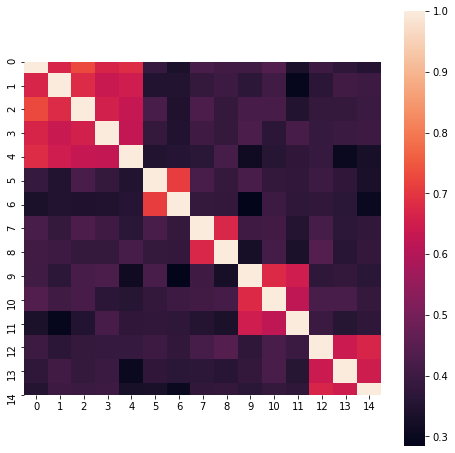

In [8]:
print('The heatmap of the generated correlation matrix is:')

plt.figure(figsize = (8,8))
ax = sns.heatmap(corr_matrix, square = True)

### Shuffling generated matrix

We are shuffling the generated correlation matrix to see the efficacy of ONC clustering in recovering the shuffled matrix to its initial state where the intra-block correlation is high and the inter-block correlation is low.

In [9]:
# Initial order of elements
corr_id = list(corr_matrix.index.values)

print('Order of elements before the shuffle:')
corr_id

Order of elements before the shuffle:


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [10]:
# Order of elements after the shuffle
newindex = shuffle(corr_id)

print('Order of elements after the shuffle:')
newindex

Order of elements after the shuffle:


[0, 6, 4, 14, 11, 12, 10, 7, 5, 3, 2, 8, 9, 1, 13]

Heatmap of the reordered correlation matrix is:


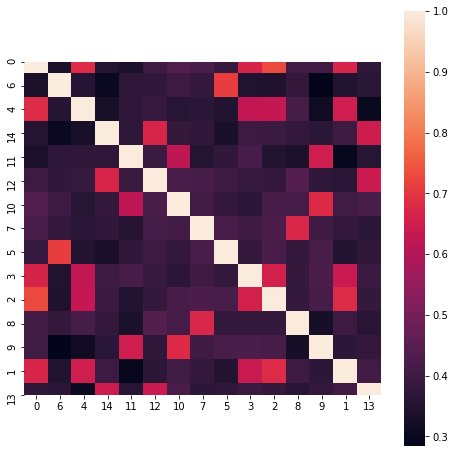

In [11]:
# Reordering the correlation matrix based on new shuffled order
corr_matrix = corr_matrix.iloc[newindex] # Reorder rows
corr_matrix = corr_matrix.iloc[:,newindex] # Reordering columns 

print ('Heatmap of the reordered correlation matrix is:')
plt.figure(figsize = (8,8))
ax = sns.heatmap(corr_matrix, square = True)

### Running the ONC algorithm

The heat map of the resulting correlation matrix of the ONC algorithm is:


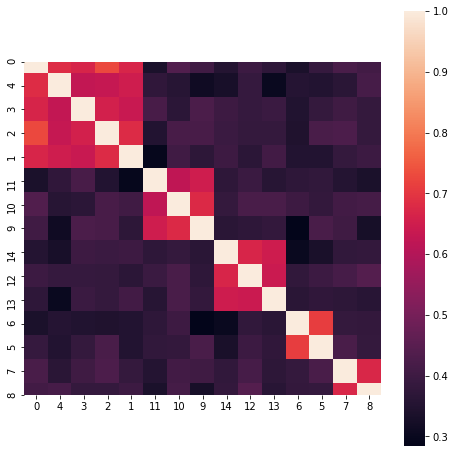

In [12]:
# Applying the ONC algorithm on the matrix

clustered_matrix, clusters, silh_scores = ml.clustering.get_onc_clusters(corr_matrix, 10)

print('The heat map of the resulting correlation matrix of the ONC algorithm is:')
plt.figure(figsize = (8,8))
ax = sns.heatmap(clustered_matrix, square = True)

In [13]:
print('Clusters created by the ONC algorithm are:')
clusters

Clusters created by the ONC algorithm are:


{0: [0, 4, 3, 2, 1], 1: [11, 10, 9], 2: [14, 12, 13], 3: [6, 5], 4: [7, 8]}

### Analysis of the results

As seen from the resulting correlation matrix from the ONC algorithm, discovered clusters are the same as in the originally created random correlation matrix. The only difference is the order of these clusters in the matrix. 

The tool used in the ONC algorithm to determine the optimal number of clusters and the optimal clustering is the Silhouette Score. The Silhouette Score measures the similarities of objects to their clusters and dissimilarities of objects to other clusters.

Silhouette score ranges from -1 to 1, where a higher score means that the object is more similar to its cluster and is more different from other clusters, and the opposite for a lower score.

According to the book __Machine Learning for Asset Managers__, by _Marcos M. Lopez de Prado_, the Silhouette Scores formula is:

$$S_i = \frac{b_i - a_i}{max \{a_i, b_i \}}$$

where:

$S_i$ = Silhouette Score

$a_i$ = the average distance between i and all other components in the same cluster

$b_i$ = the average distance between i and all the components in the nearest cluster where i is not included


### Plotting Silhouette Scores for elements in each cluster

In [14]:
# Created clusters

print('The elements are clustered as follows:')
clusters

The elements are clustered as follows:


{0: [0, 4, 3, 2, 1], 1: [11, 10, 9], 2: [14, 12, 13], 3: [6, 5], 4: [7, 8]}

In [15]:
# Assigning id of a corresponding cluster to each element

newlabels = np.zeros(len(clustered_matrix.columns))
listIndex = list(clustered_matrix.index)

for i in listIndex: 
    for k,v in clusters.items():
        for el in v:
            if el == i:
                newlabels[i] = k

print('Cluster id of each element:')
newlabels

Cluster id of each element:


array([0., 0., 0., 0., 0., 3., 3., 4., 4., 1., 1., 1., 2., 2., 2.])

In [16]:
# Silhouette score for each element

print('The Silhouette Scores of the ONC clustering elements are:')
silh_scores

The Silhouette Scores of the ONC clustering elements are:


0     0.325480
6     0.338679
4     0.283192
14    0.290760
11    0.270244
12    0.256348
10    0.260202
7     0.287043
5     0.327181
3     0.283301
2     0.314962
8     0.295280
9     0.303011
1     0.301594
13    0.277670
dtype: float64

In [17]:
# Transforming Silhouette Scores into an array

appendedSilhouette = [silh_scores[i] for i in listIndex]
appendedSilhouette = np.array(appendedSilhouette)

appendedSilhouette

array([0.32548021, 0.28319183, 0.28330072, 0.31496161, 0.3015943 ,
       0.27024411, 0.26020225, 0.30301078, 0.29075988, 0.25634789,
       0.27767025, 0.33867943, 0.32718132, 0.28704265, 0.29527969])

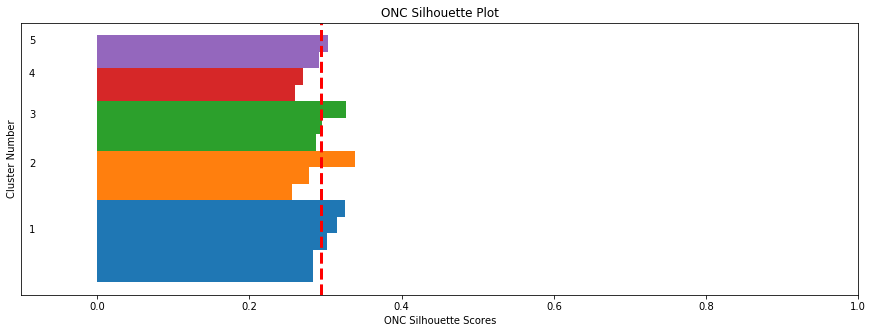

In [18]:
# Plotting ONC Silhouette Scores for each cluster 

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)


y_lower, y_upper = 0, 0
for i, c in enumerate(np.unique(newlabels)):
    
        icluster_silhouette_values = appendedSilhouette[newlabels == c]
        icluster_silhouette_values.sort()
        
        y_upper += len(icluster_silhouette_values)
        ax.barh(range(y_lower, y_upper), icluster_silhouette_values, height=1)
        ax.text(-0.09, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(icluster_silhouette_values)

#Plotting the Average of ONC Silhouette Scores
silavg = np.mean(silh_scores.values)
ax.axvline(silavg, linestyle='--', linewidth=3, color='red')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.set_xlabel('ONC Silhouette Scores')
ax.set_ylabel('Cluster Number')
ax.set_title('ONC Silhouette Plot', y=1);


## Conclusion

The ONC algorithm has recovered 5 clusters from the shuffled correlation matrix. The result is consistent with the number of intended blocks in the pre-shuffled matrix.

The average Silhouette Score is around 0.3. Each cluster except for 4th has at least one silhouette score higher than the average value.

One should remember that the ONC algorithm is somewhat random as the KMeans algorithm inside of it can output different clustering for the same inputs. This is the reason the KMeans inside of the ONC algorithm is run multiple times with the same inputs to obtain the best clusterization.